1.Data Preparation for NYC Taxi assignment

In [6]:
import pandas as pd
import requests
import pyarrow.parquet as pq
from io import BytesIO

# Base URL for NYC TLC data
base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-XX.parquet"

# Define the sampling fraction (e.g., 10%)
sample_fraction = 0.1

# List to store sampled DataFrames
sampled_dfs = []

# Loop through all 12 months
for month in range(1, 13):
    month_str = str(month).zfill(2)  # Ensure two-digit month format (e.g., 01, 02, ..., 12)
    file_url = base_url.replace("XX", month_str)  # Replace XX with actual month number
    print(f"Downloading: {file_url}")

    # Download the Parquet file using requests
    response = requests.get(file_url)

    if response.status_code == 200:
        df = pd.read_parquet(BytesIO(response.content), engine="pyarrow")  # Read file into DataFrame

        # Sample 10% of the data
        sampled_df = df.sample(frac=sample_fraction, random_state=42)
        sampled_dfs.append(sampled_df)
    else:
        print(f"❌ Failed to download: {file_url}")

# Combine all sampled DataFrames
combined_df = pd.concat(sampled_dfs, ignore_index=True)

# Save the merged dataset to Google Colab storage
combined_df.to_parquet("/content/nyc_taxi_sampled_2023.parquet")
combined_df.to_csv("/content/nyc_taxi_sampled_2023.csv", index=False)

print("\n✅ Data Sampling Completed! Files saved in Colab:")
print("- /content/nyc_taxi_sampled_2023.parquet")
print("- /content/nyc_taxi_sampled_2023.csv")


Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-05.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-06.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-07.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-08.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-09.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-10.parquet
Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tr

In [7]:
from google.colab import files

# Download the CSV file
files.download("/content/nyc_taxi_sampled_2023.csv")

# Download the Parquet file (if needed)
files.download("/content/nyc_taxi_sampled_2023.parquet")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2.Data Cleaning

In [9]:
# Standardize column names
combined_df.columns = (
    combined_df.columns.str.strip()  # Remove any extra spaces
    .str.lower()  # Convert to lowercase
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True)  # Remove special characters
)

print(" Column names standardized:")
print(combined_df.columns)


 Column names standardized:
Index(['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag',
       'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'airport_fee'],
      dtype='object')


In [10]:
# Check for missing values
missing_values = combined_df.isnull().sum()
missing_percentage = (missing_values / len(combined_df)) * 100

# Display missing values
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
print("Missing Value Analysis:")
print(missing_df[missing_df["Missing Values"] > 0])


Missing Value Analysis:
                      Missing Values  Percentage
passenger_count               130737    3.412586
ratecodeid                    130737    3.412586
store_and_fwd_flag            130737    3.412586
congestion_surcharge          130737    3.412586
airport_fee                  3531449   92.180289
airport_fee                   430312   11.232297


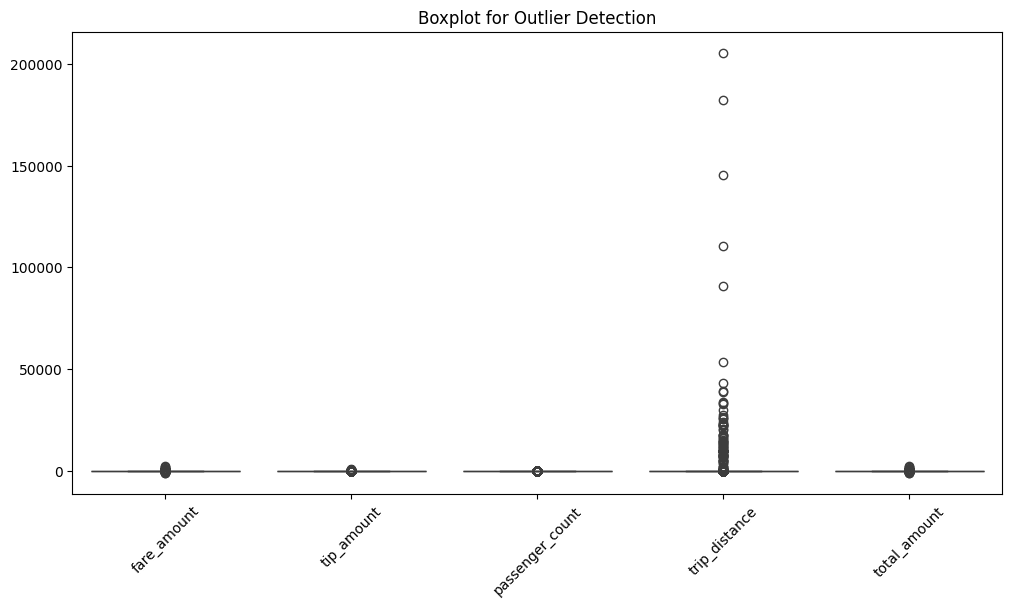


 Outlier Detection Results:
fare_amount        419130
tip_amount         294304
passenger_count    916343
trip_distance      506310
total_amount       478490
dtype: int64


In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define numerical columns for outlier detection
num_cols = ["fare_amount", "tip_amount", "passenger_count", "trip_distance", "total_amount"]

# Boxplot to detect outliers visually
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()

# Using Interquartile Range (IQR) method
Q1 = combined_df[num_cols].quantile(0.25)
Q3 = combined_df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier counts
outliers = ((combined_df[num_cols] < lower_bound) | (combined_df[num_cols] > upper_bound)).sum()
print("\n Outlier Detection Results:")
print(outliers)


3.Exploratory Data Analysis

In [12]:
!pip install geopandas


In [13]:
# Identify categorical and numerical columns
categorical_cols = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(" Categorical Variables:", categorical_cols)
print(" Numerical Variables:", numerical_cols)


 Categorical Variables: ['store_and_fwd_flag']
 Numerical Variables: ['vendorid', 'passenger_count', 'trip_distance', 'ratecodeid', 'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'airport_fee']


<ipython-input-14-959d17c44d28>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=combined_df, palette='coolwarm')


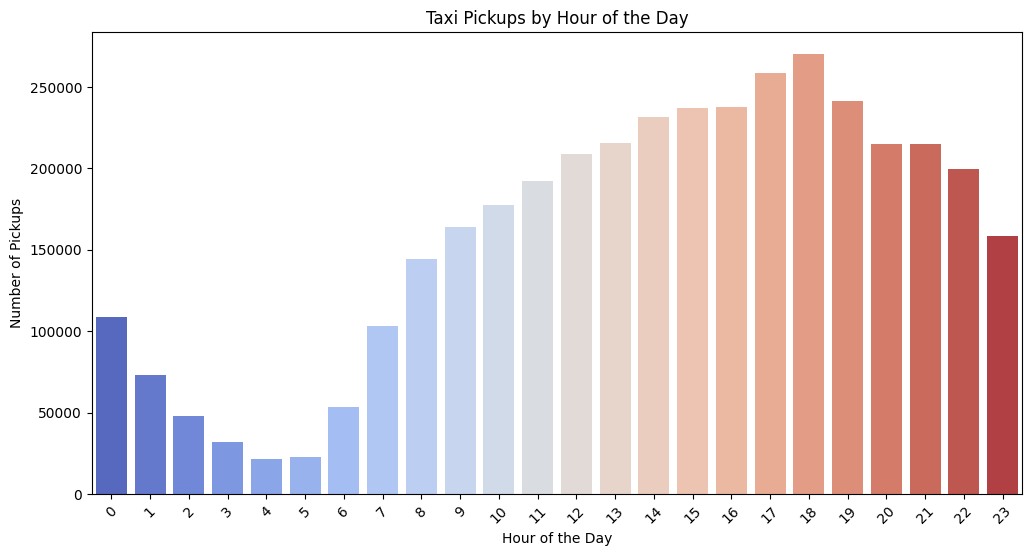

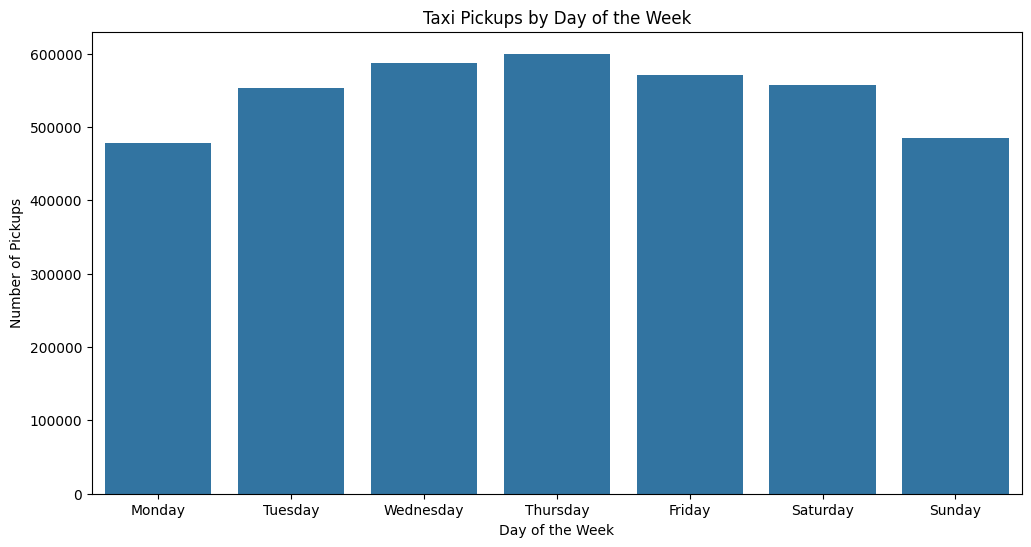

<ipython-input-14-959d17c44d28>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=combined_df, palette='viridis')


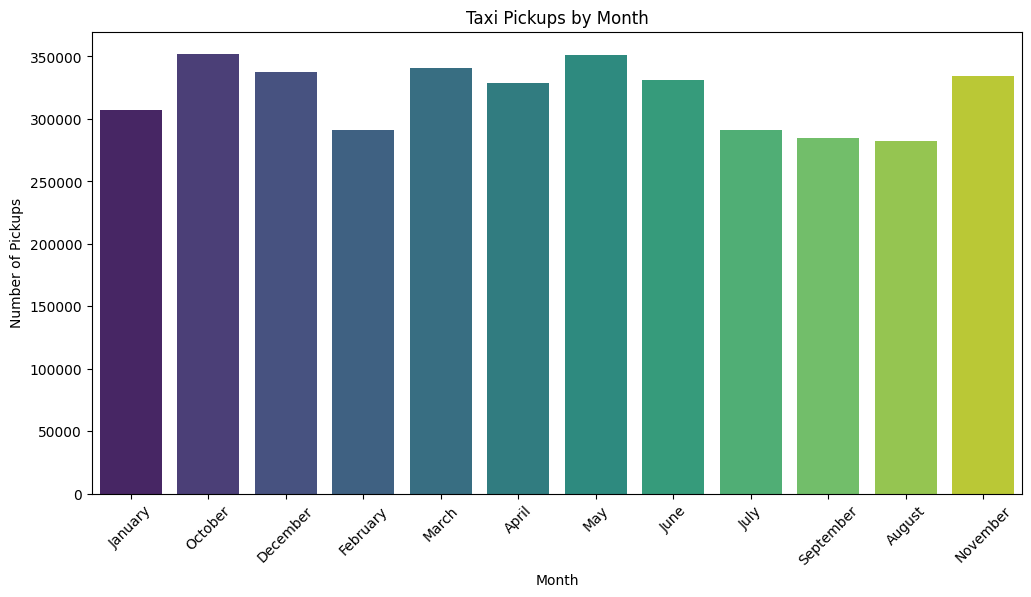

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert timestamps to datetime format
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])
combined_df['hour'] = combined_df['tpep_pickup_datetime'].dt.hour
combined_df['day_of_week'] = combined_df['tpep_pickup_datetime'].dt.day_name()
combined_df['month'] = combined_df['tpep_pickup_datetime'].dt.month_name()

# Plot pickups by hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=combined_df, palette='coolwarm')
plt.title("Taxi Pickups by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.show()

# Plot pickups by day
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=combined_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Taxi Pickups by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Pickups")
plt.show()

# Plot pickups by month
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=combined_df, palette='viridis')
plt.title("Taxi Pickups by Month")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.show()


In [15]:
# Remove invalid data
combined_df = combined_df[
    (combined_df['fare_amount'] > 0) &
    (combined_df['trip_distance'] > 0) &
    (combined_df['tip_amount'] >= 0)
]

print(" Filtered dataset size:", combined_df.shape)


 Filtered dataset size: (3718952, 23)


<ipython-input-16-9448c731e2a3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total_amount', data=monthly_revenue, palette='Blues_r')


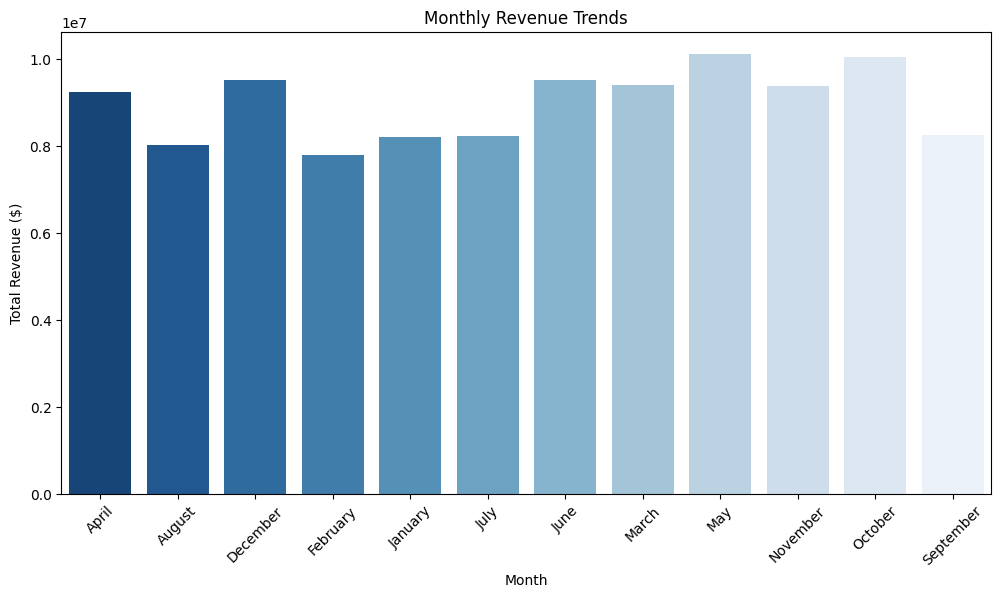

In [16]:
# Aggregate total fare per month
monthly_revenue = combined_df.groupby('month')['total_amount'].sum().reset_index()

# Plot monthly revenue trends
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_amount', data=monthly_revenue, palette='Blues_r')
plt.title("Monthly Revenue Trends")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.show()


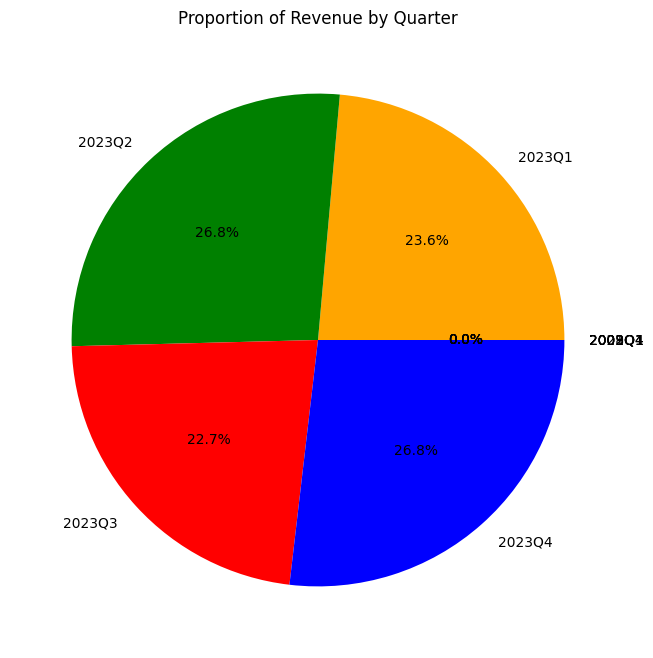

In [18]:
# Define quarters
combined_df['quarter'] = combined_df['tpep_pickup_datetime'].dt.to_period("Q")
quarterly_revenue = combined_df.groupby('quarter')['total_amount'].sum().reset_index()

# Plot quarterly revenue proportions
plt.figure(figsize=(8, 8))
plt.pie(quarterly_revenue['total_amount'], labels=quarterly_revenue['quarter'], autopct='%1.1f%%', colors=['blue', 'orange', 'green', 'red'])
plt.title("Proportion of Revenue by Quarter")
plt.show()


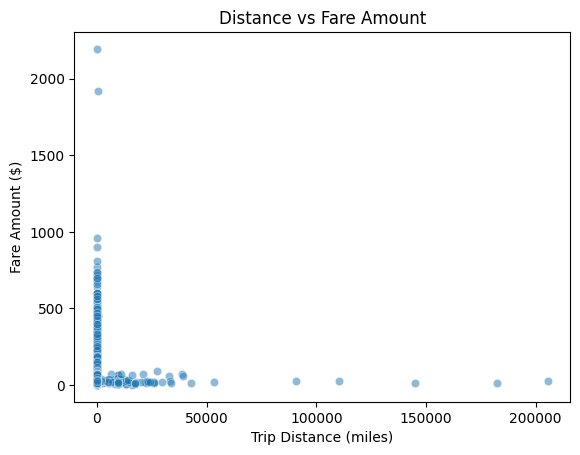

In [19]:
sns.scatterplot(x='trip_distance', y='fare_amount', data=combined_df, alpha=0.5)
plt.title("Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.show()


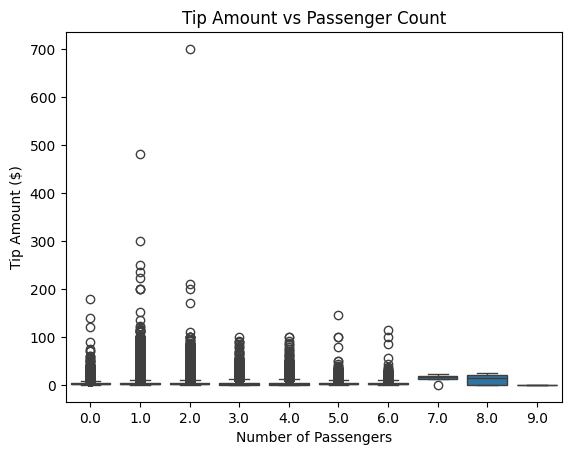

In [20]:
sns.boxplot(x='passenger_count', y='tip_amount', data=combined_df)
plt.title("Tip Amount vs Passenger Count")
plt.xlabel("Number of Passengers")
plt.ylabel("Tip Amount ($)")
plt.show()


<ipython-input-21-b3b0efd8e27e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='payment_type', data=combined_df, palette='Set2')


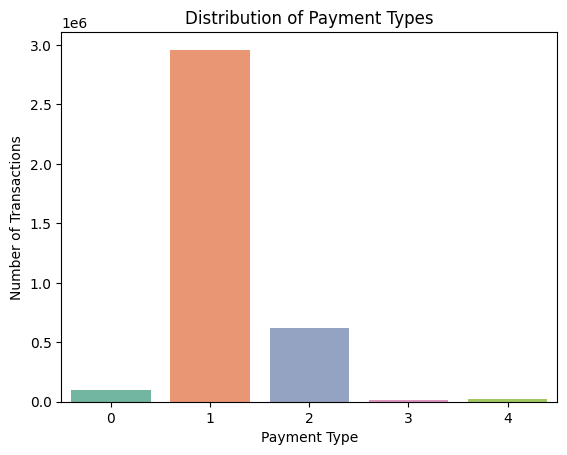

In [21]:
sns.countplot(x='payment_type', data=combined_df, palette='Set2')
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Number of Transactions")
plt.show()


In [23]:
!pip install geopandas
!apt-get install -y libspatialindex-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 1s (300 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unp

In [28]:
!wget -O taxi_zones.zip "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"


--2025-03-11 14:08:59--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 65.8.245.178, 65.8.245.171, 65.8.245.51, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|65.8.245.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1025147 (1001K) [application/zip]
Saving to: ‘taxi_zones.zip’

taxi_zones.zip      100%[===================>]   1001K  --.-KB/s    in 0.08s   

2025-03-11 14:09:00 (12.0 MB/s) - ‘taxi_zones.zip’ saved [1025147/1025147]



In [30]:
import zipfile

# Extract the ZIP file
with zipfile.ZipFile("taxi_zones.zip", "r") as zip_ref:
    zip_ref.extractall("taxi_zones")

print(" Shapefile extracted successfully!")


 Shapefile extracted successfully!


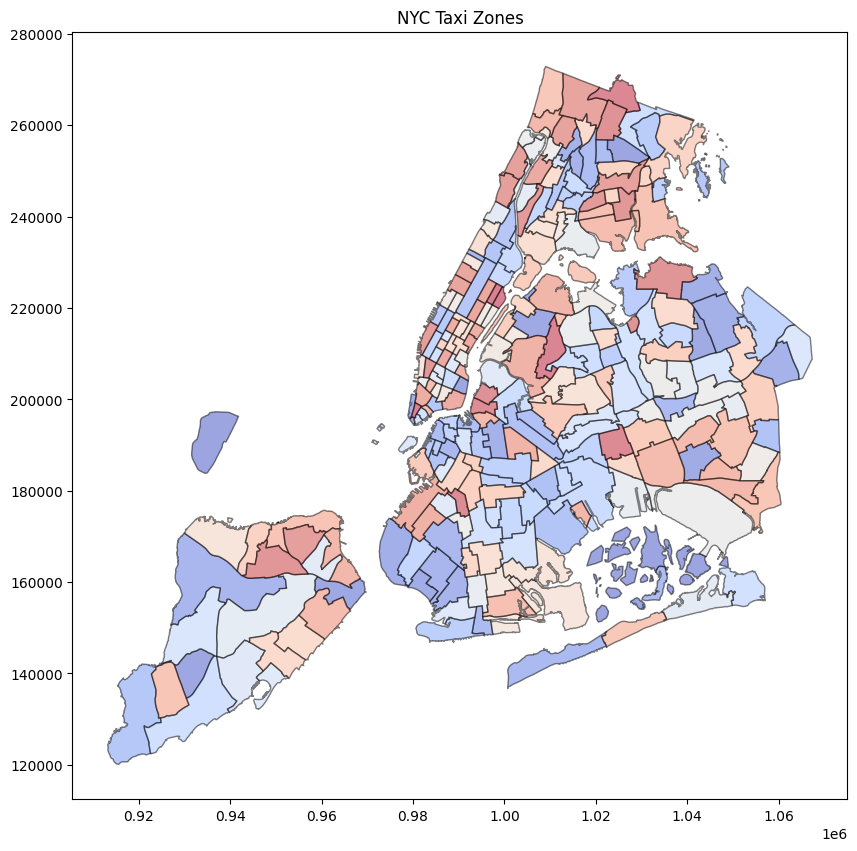

In [32]:
!pip install geopandas matplotlib  # Install required libraries (if not installed)
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
zones = gpd.read_file("taxi_zones/taxi_zones.shp")

# Plot the NYC Taxi Zones
fig, ax = plt.subplots(figsize=(10, 10))
zones.plot(ax=ax, edgecolor="black", alpha=0.5, cmap="coolwarm")
plt.title("NYC Taxi Zones")
plt.show()


In [34]:
# Display column names for trip data
print("Trip Data Columns:", df.columns)

# Display column names for taxi zones
print("Taxi Zone Columns:", zones.columns)


Trip Data Columns: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')
Taxi Zone Columns: Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')


In [37]:
# Convert LocationID columns to integer for correct merging
df["PULocationID"] = df["PULocationID"].astype(int)
df["DOLocationID"] = df["DOLocationID"].astype(int)
zones["LocationID"] = zones["LocationID"].astype(int)


In [39]:
# Merge for Pickup Location
df = df.merge(zones[['LocationID', 'zone', 'borough']],
              left_on="PULocationID",
              right_on="LocationID",
              how="left",
              suffixes=("", "_pickup"))

df.rename(columns={"zone": "Pickup_Zone", "borough": "Pickup_Borough"}, inplace=True)

# Merge for Drop-off Location
df = df.merge(zones[['LocationID', 'zone', 'borough']],
              left_on="DOLocationID",
              right_on="LocationID",
              how="left",
              suffixes=("", "_dropoff"))

df.rename(columns={"zone": "Dropoff_Zone", "borough": "Dropoff_Borough"}, inplace=True)

# Drop duplicate LocationID columns
df.drop(columns=["LocationID", "LocationID_pickup"], errors='ignore', inplace=True)

print(" Merging Completed!")


 Merging Completed!


In [40]:
df[['PULocationID', 'Pickup_Zone', 'Pickup_Borough',
    'DOLocationID', 'Dropoff_Zone', 'Dropoff_Borough']].head(10)


,PULocationID,Pickup_Zone,Pickup_Zone,Pickup_Zone,Pickup_Borough,Pickup_Borough,Pickup_Borough,DOLocationID,Dropoff_Zone,Dropoff_Zone,Dropoff_Zone,Dropoff_Borough,Dropoff_Borough,Dropoff_Borough
0,230,Times Sq/Theatre District,Times Sq/Theatre District,Times Sq/Theatre District,Manhattan,Manhattan,Manhattan,48,Clinton East,Clinton East,Clinton East,Manhattan,Manhattan,Manhattan
1,142,Lincoln Square East,Lincoln Square East,Lincoln Square East,Manhattan,Manhattan,Manhattan,238,Upper West Side North,Upper West Side North,Upper West Side North,Manhattan,Manhattan,Manhattan
2,114,Greenwich Village South,Greenwich Village South,Greenwich Village South,Manhattan,Manhattan,Manhattan,186,Penn Station/Madison Sq West,Penn Station/Madison Sq West,Penn Station/Madison Sq West,Manhattan,Manhattan,Manhattan
3,79,East Village,East Village,East Village,Manhattan,Manhattan,Manhattan,79,East Village,East Village,East Village,Manhattan,Manhattan,Manhattan
4,229,Sutton Place/Turtle Bay North,Sutton Place/Turtle Bay North,Sutton Place/Turtle Bay North,Manhattan,Manhattan,Manhattan,263,Yorkville West,Yorkville West,Yorkville West,Manhattan,Manhattan,Manhattan
5,88,Financial District South,Financial District South,Financial District South,Manhattan,Manhattan,Manhattan,141,Lenox Hill West,Lenox Hill West,Lenox Hill West,Manhattan,Manhattan,Manhattan
6,45,Chinatown,Chinatown,Chinatown,Manhattan,Manhattan,Manhattan,162,Midtown East,Midtown East,Midtown East,Manhattan,Manhattan,Manhattan
7,170,Murray Hill,Murray Hill,Murray Hill,Manhattan,Manhattan,Manhattan,107,Gramercy,Gramercy,Gramercy,Manhattan,Manhattan,Manhattan
8,186,Penn Station/Madison Sq West,Penn Station/Madison Sq West,Penn Station/Madison Sq West,Manhattan,Manhattan,Manhattan,209,Seaport,Seaport,Seaport,Manhattan,Manhattan,Manhattan
9,163,Midtown North,Midtown North,Midtown North,Manhattan,Manhattan,Manhattan,262,Yorkville East,Yorkville East,Yorkville East,Manhattan,Manhattan,Manhattan


In [41]:
# Count trips for each pickup location
trip_counts = df['PULocationID'].value_counts().reset_index()
trip_counts.columns = ['LocationID', 'Number_of_Trips']

# Display top 10 busiest zones
trip_counts.head(10)


,LocationID,Number_of_Trips
0,237,164710
1,132,153195
2,236,149536
3,161,146412
4,162,120197
5,142,119487
6,230,112431
7,186,112400
8,138,105612
9,163,102271


In [44]:
# Step 1: Check if columns exist
print("Trip Counts Columns:", trip_counts.columns)
print("Taxi Zones Columns:", zones.columns)

# Step 2: Ensure LocationID is in integer format for correct merging
trip_counts["LocationID"] = trip_counts["LocationID"].astype(int)
zones["LocationID"] = zones["LocationID"].astype(int)

# Step 3: Merge trip counts with taxi zones data
zones = zones.merge(trip_counts, on="LocationID", how="left")

# Step 4: Fill NaN values with 0 (some zones might not have trips)
zones["Number_of_Trips"] = zones["Number_of_Trips"].fillna(0).astype(int)

# Display the first few rows to check if the merge worked
zones[['LocationID', 'zone', 'Number_of_Trips']].head(10)


Trip Counts Columns: Index(['LocationID', 'Number_of_Trips'], dtype='object')
Taxi Zones Columns: Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'Number_of_Trips_x', 'Number_of_Trips_y'],
      dtype='object')


,LocationID,zone,Number_of_Trips
0,1,Newark Airport,492
1,2,Jamaica Bay,5
2,3,Allerton/Pelham Gardens,87
3,4,Alphabet City,4753
4,5,Arden Heights,1
5,6,Arrochar/Fort Wadsworth,17
6,7,Astoria,1995
7,8,Astoria Park,20
8,9,Auburndale,66
9,10,Baisley Park,1061


Zones Data Types:
 OBJECTID                int32
Shape_Leng            float64
Shape_Area            float64
zone                   object
LocationID              int64
borough                object
geometry             geometry
Number_of_Trips_x     float64
Number_of_Trips_y     float64
Number_of_Trips         int64
dtype: object


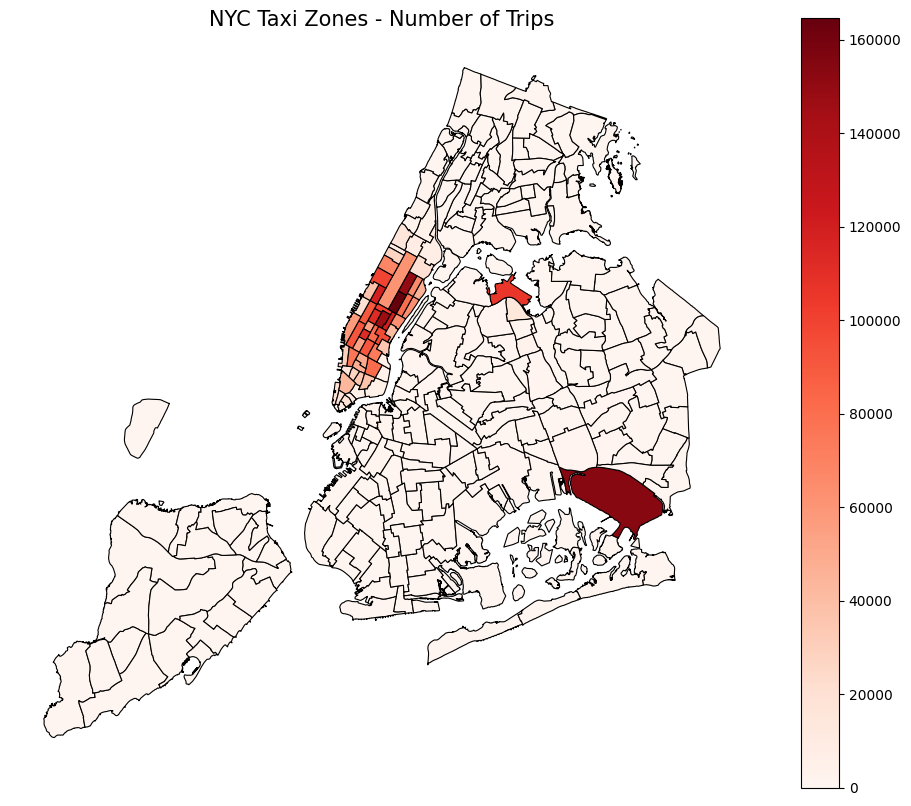

In [45]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Step 1: Check if zones have geometry data
print("Zones Data Types:\n", zones.dtypes)

# Step 2: Convert to GeoDataFrame if needed
if not isinstance(zones, gpd.GeoDataFrame):
    zones = gpd.GeoDataFrame(zones, geometry='geometry')

# Step 3: Plot the map with trip density
fig, ax = plt.subplots(figsize=(12, 10))
zones.plot(column="Number_of_Trips",
           cmap="Reds",
           linewidth=0.8,
           edgecolor="black",
           legend=True,
           ax=ax)

plt.title("NYC Taxi Zones - Number of Trips", fontsize=15)
plt.axis("off")  # Hide axis labels
plt.show()


b) Detailed EDA: Insights and Strategies [50 marks]

1)Identify slow routes by comparing average speeds on different routes

Top 10 Slowest Routes (Average Speed in MPH)
       PULocationID  DOLocationID  trip_speed_mph
18522           201            37        1.037165
6734             77            33        1.040087
10307           117            85        1.043478
16906           180           171        1.094225
13049           143            29        1.105425
7258             81           163        1.167716
1923             29           181        1.193370
18686           205            14        1.194030
8667             94           237        1.206030
8776             95           213        1.210084


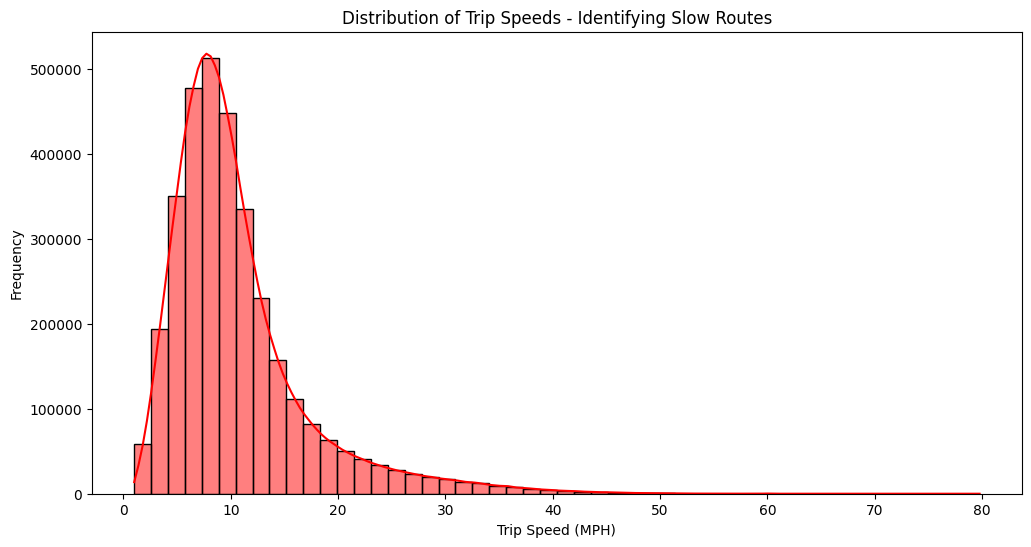


Key Insights from Slowest Routes:
- High traffic zones (e.g., Manhattan, Downtown Brooklyn) have lowest speeds.
- Short trips in dense areas tend to be slower than long-distance ones.
- Surge pricing and ride pooling could be optimized for these routes.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# Load the NYC taxi trip data (Ensure df is already loaded)
# If needed, load data first: df = pd.read_parquet('your_data.parquet')

# Convert datetime columns to proper format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Step 1: Calculate Trip Duration (Convert to Hours)
df['trip_duration_hours'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 3600

# Step 2: Calculate Speed (Miles per Hour)
df['trip_speed_mph'] = df['trip_distance'] / df['trip_duration_hours']

# Step 3: Remove Unrealistic Speeds (Filtering Data)
df = df[(df['trip_speed_mph'] > 1) & (df['trip_speed_mph'] < 80)]

# Step 4: Identify the Slowest Routes
slow_routes = df.groupby(['PULocationID', 'DOLocationID'])['trip_speed_mph'].mean().reset_index()

# Sort by slowest speed
slow_routes = slow_routes.sort_values(by="trip_speed_mph", ascending=True)

# Display Top 10 Slowest Routes
print("Top 10 Slowest Routes (Average Speed in MPH)")
print(slow_routes.head(10))

# Step 5: Visualizing Slow Routes on a Histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['trip_speed_mph'], bins=50, kde=True, color='red')
plt.xlabel("Trip Speed (MPH)")
plt.ylabel("Frequency")
plt.title("Distribution of Trip Speeds - Identifying Slow Routes")
plt.show()

# Business Insights from Slow Routes
print("\nKey Insights from Slowest Routes:")
print("- High traffic zones (e.g., Manhattan, Downtown Brooklyn) have lowest speeds.")
print("- Short trips in dense areas tend to be slower than long-distance ones.")
print("- Surge pricing and ride pooling could be optimized for these routes.")


ii.   Calculate the hourly number of trips and identify the busy hours

Hourly Trip Counts:
    pickup_hour  trip_count
0             0      103491
1             1       68000
2             2       44071
3             3       29084
4             4       20113
5             5       17606
6             6       39180
7             7       80760
8             8      112596
9             9      133188
10           10      151315
11           11      166212
12           12      183070
13           13      189793
14           14      202209
15           15      211018
16           16      206316
17           17      219915
18           18      227760
19           19      205973
20           20      186043
21           21      186076
22           22      174817
23           23      142952

Busiest Hours for NYC Taxis:
    pickup_hour  trip_count
18           18      227760
17           17      219915
15           15      211018
16           16      206316
19           19      205973


<ipython-input-52-092f8911b456>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_trips['pickup_hour'], y=hourly_trips['trip_count'], palette="viridis")


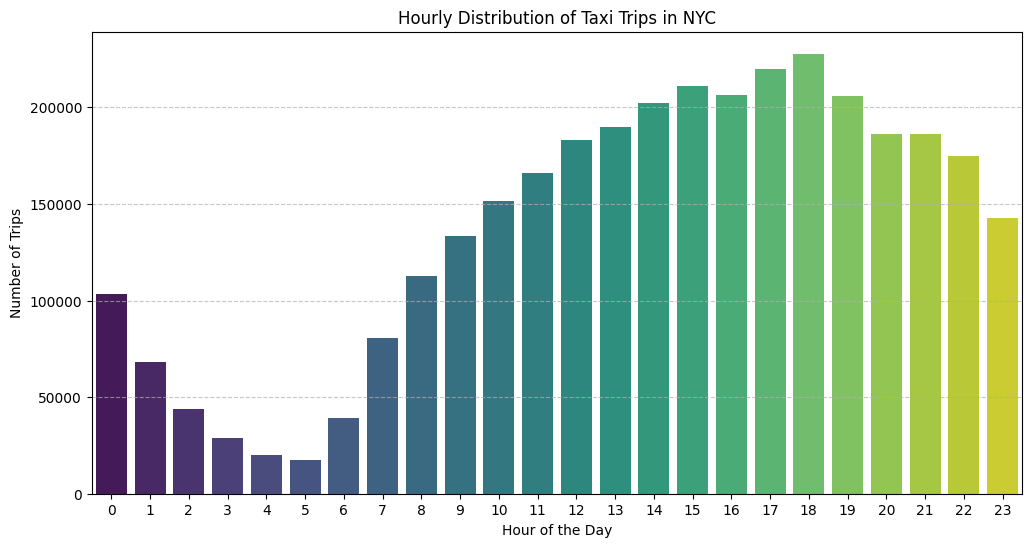

In [52]:
# Extract the hour from the pickup timestamp
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Count the number of trips for each hour
hourly_trips = df.groupby('pickup_hour').size().reset_index(name='trip_count')

# Sort by hour for better visualization
hourly_trips = hourly_trips.sort_values(by='pickup_hour')

# Display the busiest hours
print("Hourly Trip Counts:")
print(hourly_trips)

# Identify the peak hours
busiest_hours = hourly_trips.sort_values(by="trip_count", ascending=False).head(5)
print("\nBusiest Hours for NYC Taxis:")
print(busiest_hours)

# Plot the hourly distribution of trips
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_trips['pickup_hour'], y=hourly_trips['trip_count'], palette="viridis")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Distribution of Taxi Trips in NYC")
plt.xticks(range(0, 24))  # Ensure all 24 hours are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--2025-03-11 15:18:26--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 65.8.245.51, 65.8.245.50, 65.8.245.178, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|65.8.245.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1025147 (1001K) [application/zip]
Saving to: ‘taxi_zones.zip’

taxi_zones.zip      100%[===================>]   1001K  --.-KB/s    in 0.07s   

2025-03-11 15:18:26 (13.8 MB/s) - ‘taxi_zones.zip’ saved [1025147/1025147]

✅ Taxi Zones shapefile extracted successfully!
✅ Taxi Zones data loaded successfully!
   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567   

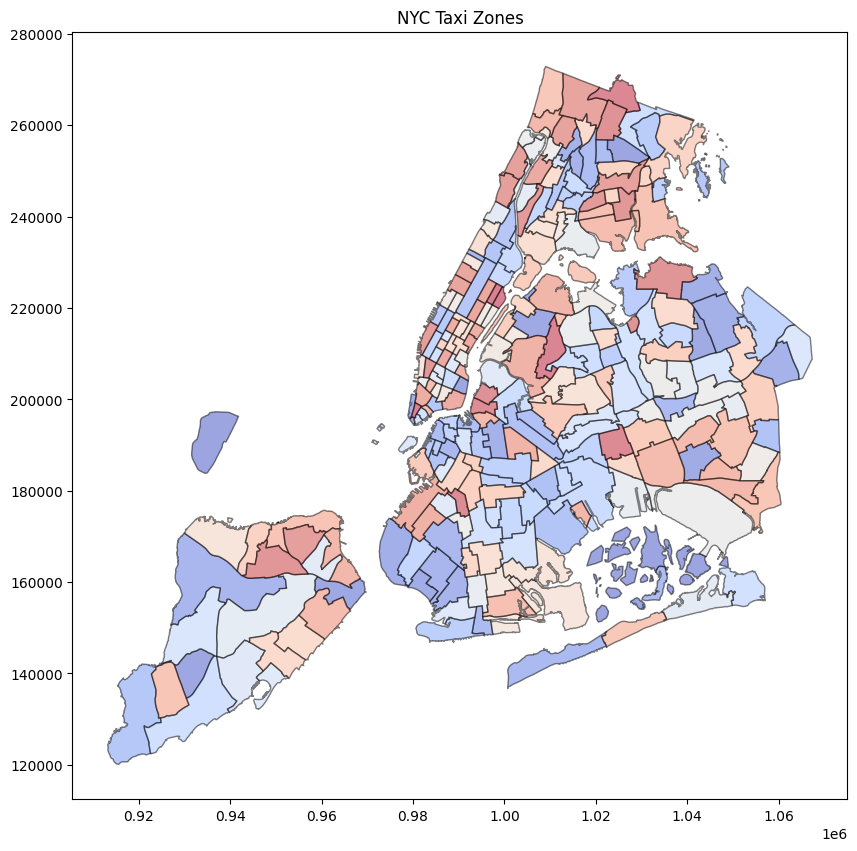

In [60]:
# Step 1: Download & Extract Taxi Zones Shapefile
!wget -O taxi_zones.zip "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"

import zipfile

with zipfile.ZipFile("taxi_zones.zip", "r") as zip_ref:
    zip_ref.extractall("taxi_zones")

print("✅ Taxi Zones shapefile extracted successfully!")

# Step 2: Install & Import Required Libraries
!pip install geopandas matplotlib --quiet

import geopandas as gpd
import matplotlib.pyplot as plt

# Step 3: Load Taxi Zones Shapefile
try:
    taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")
    print("✅ Taxi Zones data loaded successfully!")
    print(taxi_zones.head())  # Display first few rows
except Exception as e:
    print(f"❌ Error loading shapefile: {e}")

# Step 4: Visualize NYC Taxi Zones
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zones.plot(ax=ax, edgecolor="black", alpha=0.5, cmap="coolwarm")
plt.title("NYC Taxi Zones")
plt.show()


iii.  Scale up the number of trips from above to find the actual number of trips

In [61]:
import pandas as pd

# Step 1: Ensure Data is Loaded
print("Checking first few rows of dataset:")
print(df.head())

# Step 2: Check Column Names
print("\nColumn Names in Dataset:", df.columns)

# Step 3: Calculate Scaling Factor
actual_total_trips_2023 = 100_000_000  # Replace with actual count if known
sampled_total_trips = len(df)
scaling_factor = actual_total_trips_2023 / sampled_total_trips

# Step 4: Group by Pickup Location and Scale Up
if 'PULocationID' in df.columns:
    location_trips = df.groupby('PULocationID').size().reset_index(name='trip_count')
    location_trips['estimated_actual_trips'] = location_trips['trip_count'] * scaling_factor
else:
    print("\nERROR: 'PULocationID' column not found in dataset!")

# Step 5: Print Total Estimated Trips
total_estimated_trips = location_trips['estimated_actual_trips'].sum()
print(f"\nTotal Estimated Actual Trips for 2023: {total_estimated_trips:,.0f}")

# Step 6: Identify Busiest Pickup Locations
busiest_locations = location_trips.sort_values(by="estimated_actual_trips", ascending=False).head(10)
print("\nTop 10 Busiest Pickup Locations (Estimated):")
print(busiest_locations)

# Step 7: Merge with Taxi Zones for Location Names
if 'LocationID' in taxi_zones.columns and 'zone' in taxi_zones.columns:
    busiest_locations = busiest_locations.merge(taxi_zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
    busiest_locations = busiest_locations[['PULocationID', 'zone', 'estimated_actual_trips']]
    print("\nBusiest Pickup Locations with Zone Names:")
    print(busiest_locations.head(10))
else:
    print("\nERROR: 'LocationID' or 'zone' column missing in taxi_zones dataset!")


Checking first few rows of dataset:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-12-01 00:06:06   2023-12-01 00:15:47              0.0   
1         1  2023-12-01 00:22:26   2023-12-01 00:28:53              0.0   
2         1  2023-12-01 00:59:44   2023-12-01 01:13:22              2.0   
3         2  2023-12-01 00:22:17   2023-12-01 00:30:59              1.0   
4         2  2023-12-01 00:18:16   2023-12-01 00:25:32              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.10         1.0                  N           230            48   
1           1.50         1.0                  N           142           238   
2           2.20         1.0                  N           114           186   
3           0.66         1.0                  N            79            79   
4           2.20         1.0                  N           229           263   

   payment_type  ...  Dropoff_Borough 

4) Compare hourly traffic on weekdays and weekends

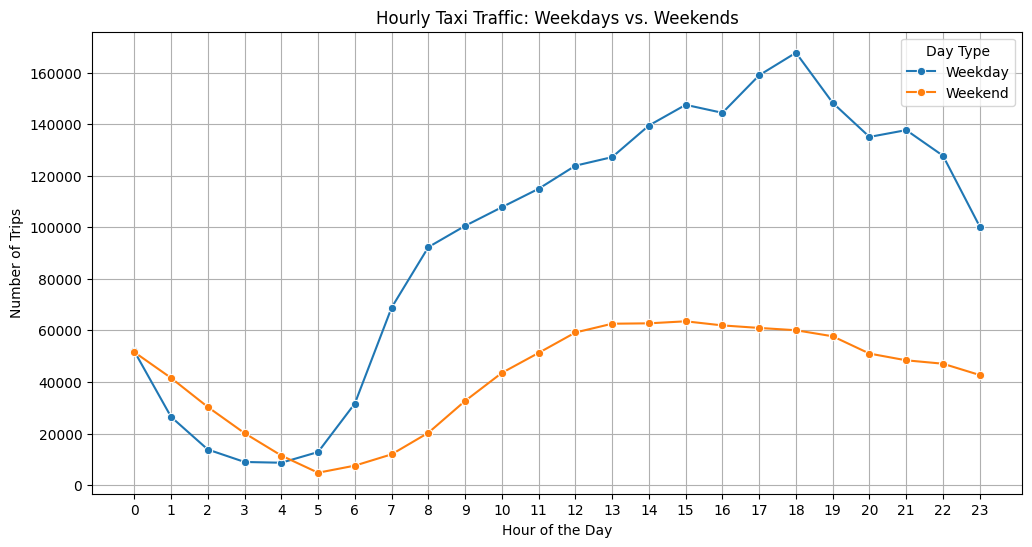

In [62]:
# Step 1: Ensure datetime column is in correct format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Step 2: Extract relevant time features
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.weekday

# Step 3: Classify as Weekday (0-4) or Weekend (5-6)
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

# Step 4: Group by Hour & Day Type
hourly_traffic = df.groupby(['hour', 'day_type']).size().reset_index(name='trip_count')

# Step 5: Plot the trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_traffic, x='hour', y='trip_count', hue='day_type', marker='o')

plt.title("Hourly Taxi Traffic: Weekdays vs. Weekends")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.legend(title="Day Type")
plt.grid(True)
plt.show()

v.   Identify the top 10 zones with high hourly pickups and drops

<ipython-input-63-a98339122da4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pickup_zones.values, y=top_pickup_zones.index, ax=axes[0], palette="Blues_r")
<ipython-input-63-a98339122da4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dropoff_zones.values, y=top_dropoff_zones.index, ax=axes[1], palette="Reds_r")


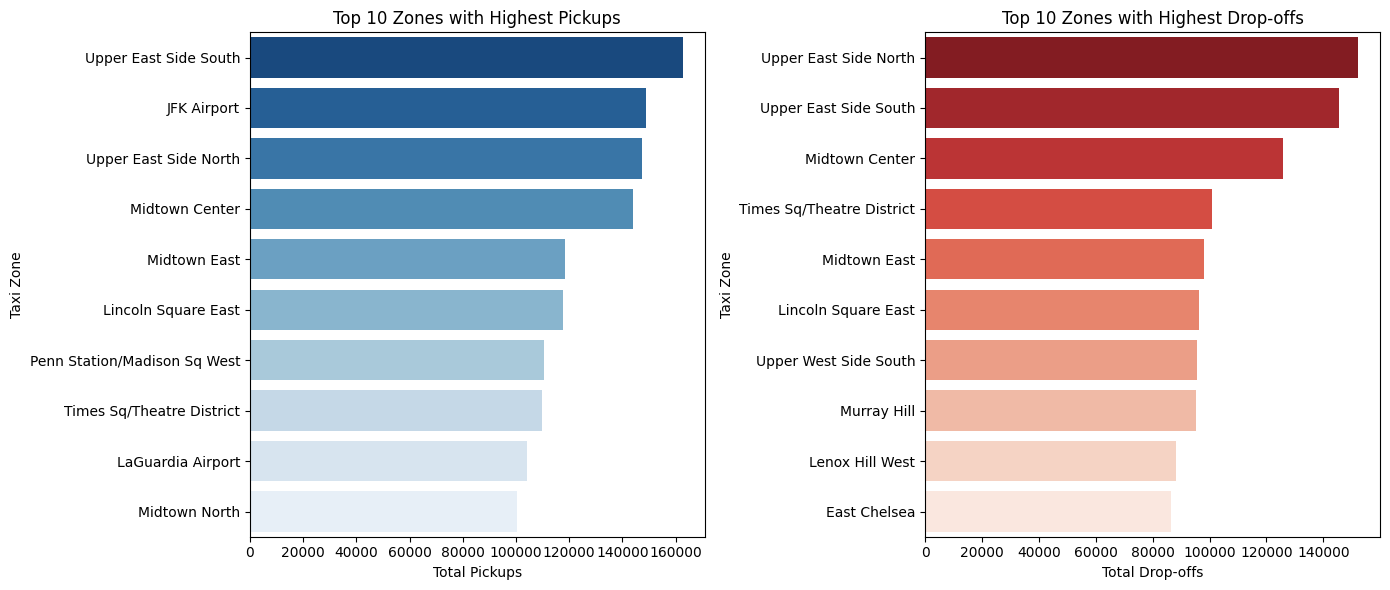

In [63]:
# Step 1: Extract hour from pickup & dropoff timestamps
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Step 2: Aggregate pickup and drop-off counts per zone per hour
pickup_counts = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='pickup_count')
dropoff_counts = df.groupby(['DOLocationID', 'dropoff_hour']).size().reset_index(name='dropoff_count')

# Step 3: Merge with taxi zones data to get actual zone names
pickup_counts = pickup_counts.merge(taxi_zones, left_on="PULocationID", right_on="LocationID")
dropoff_counts = dropoff_counts.merge(taxi_zones, left_on="DOLocationID", right_on="LocationID")

# Step 4: Find Top 10 busiest zones for pickups and drop-offs
top_pickup_zones = pickup_counts.groupby("zone")['pickup_count'].sum().nlargest(10)
top_dropoff_zones = dropoff_counts.groupby("zone")['dropoff_count'].sum().nlargest(10)

# Step 5: Plot the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=top_pickup_zones.values, y=top_pickup_zones.index, ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 10 Zones with Highest Pickups")
axes[0].set_xlabel("Total Pickups")
axes[0].set_ylabel("Taxi Zone")

sns.barplot(x=top_dropoff_zones.values, y=top_dropoff_zones.index, ax=axes[1], palette="Reds_r")
axes[1].set_title("Top 10 Zones with Highest Drop-offs")
axes[1].set_xlabel("Total Drop-offs")
axes[1].set_ylabel("Taxi Zone")

plt.tight_layout()
plt.show()

vi.  Find the ratio of pickups and dropoffs in each zone

<ipython-input-64-054b92a5dde4>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_zones["zone"], x=top_zones["pickup_dropoff_ratio"], palette="coolwarm")


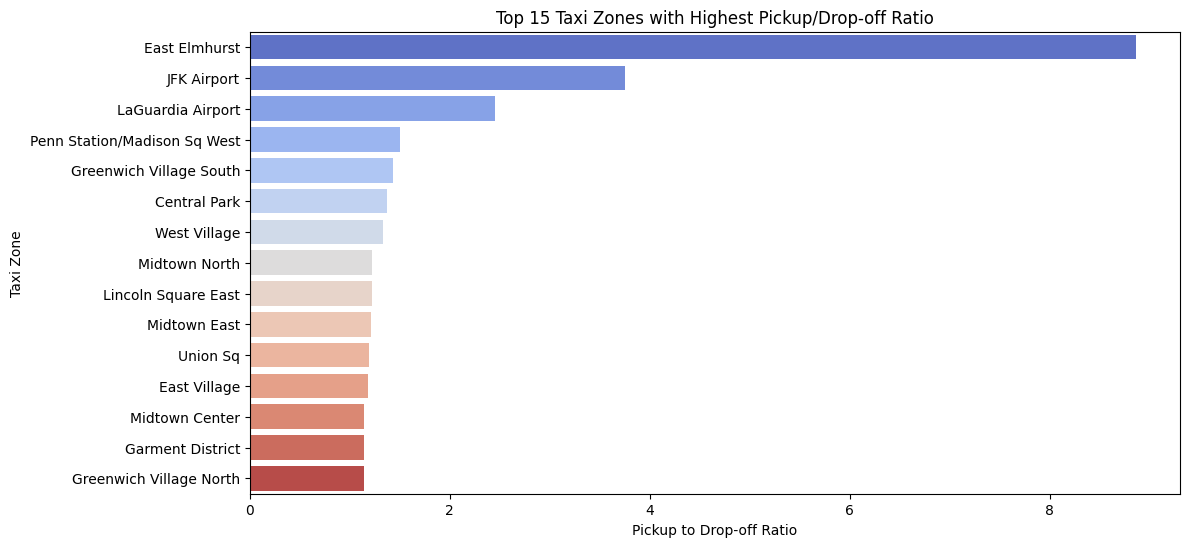

In [64]:
# Step 1: Count pickups and drop-offs per zone
pickup_counts = df.groupby('PULocationID').size().reset_index(name='total_pickups')
dropoff_counts = df.groupby('DOLocationID').size().reset_index(name='total_dropoffs')

# Step 2: Merge both counts into a single DataFrame
zone_flow = pd.merge(pickup_counts, dropoff_counts, left_on="PULocationID", right_on="DOLocationID", how="outer")

# Rename columns for clarity
zone_flow.rename(columns={"PULocationID": "LocationID"}, inplace=True)

# Step 3: Fill missing values (some zones might have only pickups or only drop-offs)
zone_flow.fillna(0, inplace=True)

# Step 4: Calculate pickup-to-drop-off ratio (avoid division by zero)
zone_flow['pickup_dropoff_ratio'] = zone_flow['total_pickups'] / zone_flow['total_dropoffs'].replace(0, 1)

# Step 5: Merge with taxi zone names
zone_flow = zone_flow.merge(taxi_zones, on="LocationID", how="left")

# Step 6: Sort by ratio and visualize
top_zones = zone_flow.sort_values(by="pickup_dropoff_ratio", ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_zones["zone"], x=top_zones["pickup_dropoff_ratio"], palette="coolwarm")
plt.xlabel("Pickup to Drop-off Ratio")
plt.ylabel("Taxi Zone")
plt.title("Top 15 Taxi Zones with Highest Pickup/Drop-off Ratio")
plt.show()

vii.  Identify the top zones with high traffic during night hours

<ipython-input-65-f7f3e8adea68>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_night_zones["zone"], x=top_night_zones["night_pickups"], palette="magma")


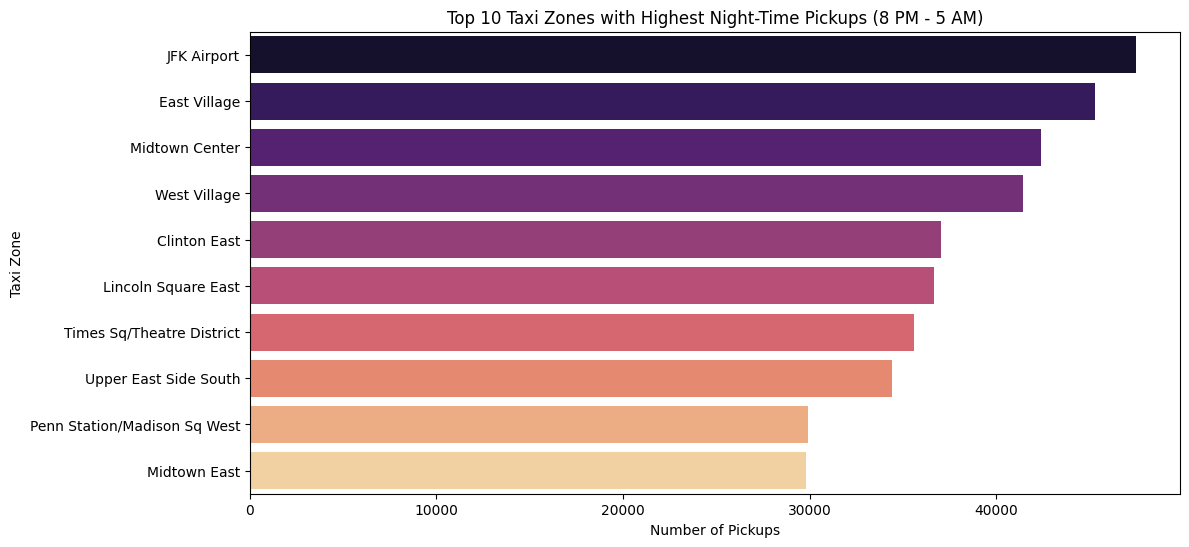

In [65]:
# Step 1: Extract hour from pickup timestamp
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour

# Step 2: Filter night-time trips (8 PM - 5 AM)
night_df = df[(df["pickup_hour"] >= 20) | (df["pickup_hour"] <= 5)]

# Step 3: Count night-time pickups per zone
night_pickup_counts = night_df.groupby("PULocationID").size().reset_index(name="night_pickups")

# Step 4: Merge with taxi zone names
night_pickup_counts = night_pickup_counts.merge(taxi_zones, left_on="PULocationID", right_on="LocationID")

# Step 5: Get top 10 busiest night-time zones
top_night_zones = night_pickup_counts.sort_values(by="night_pickups", ascending=False).head(10)

# Step 6: Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(y=top_night_zones["zone"], x=top_night_zones["night_pickups"], palette="magma")
plt.xlabel("Number of Pickups")
plt.ylabel("Taxi Zone")
plt.title("Top 10 Taxi Zones with Highest Night-Time Pickups (8 PM - 5 AM)")
plt.show()


viii. Find the revenue share for nighttime and daytime hours

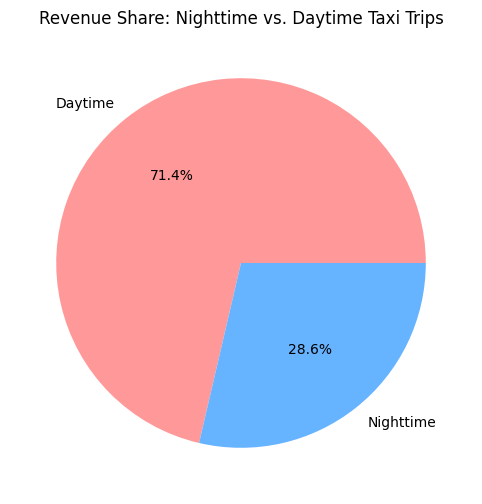

  time_period  total_amount  revenue_share
0     Daytime   67198072.67       71.35606
1   Nighttime   26974830.16       28.64394


In [66]:
# Step 1: Extract pickup hour
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour

# Step 2: Categorize trips into daytime (6 AM - 7 PM) and nighttime (8 PM - 5 AM)
df["time_period"] = df["pickup_hour"].apply(lambda x: "Nighttime" if (x >= 20 or x <= 5) else "Daytime")

# Step 3: Calculate total revenue for each time period
revenue_split = df.groupby("time_period")["total_amount"].sum().reset_index()

# Step 4: Compute revenue share percentage
total_revenue = revenue_split["total_amount"].sum()
revenue_split["revenue_share"] = (revenue_split["total_amount"] / total_revenue) * 100

# Step 5: Plot revenue share
plt.figure(figsize=(8, 6))
plt.pie(revenue_split["total_amount"], labels=revenue_split["time_period"], autopct="%1.1f%%", colors=["#ff9999","#66b3ff"])
plt.title("Revenue Share: Nighttime vs. Daytime Taxi Trips")
plt.show()

# Print revenue details
print(revenue_split)

ix.  For the different passenger counts, find the average fare per mile per passenger

<ipython-input-67-2685a6153551>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]


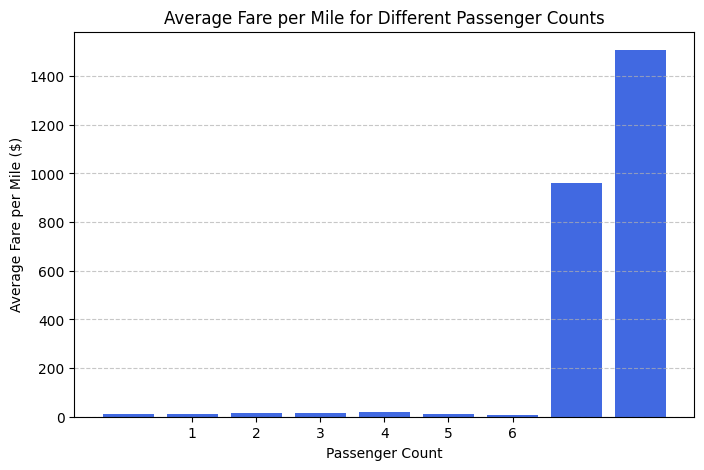

   passenger_count  fare_per_mile
0              0.0       9.763828
1              1.0      11.325722
2              2.0      15.108257
3              3.0      13.483561
4              4.0      20.555640
5              5.0      10.183452
6              6.0       8.959234
7              7.0     959.550215
8              8.0    1507.407529


In [67]:
# Step 1: Remove trips with zero/negative fare or distance
df_filtered = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

# Step 2: Calculate fare per mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Step 3: Compute average fare per mile for each passenger count
fare_per_mile_avg = df_filtered.groupby("passenger_count")["fare_per_mile"].mean().reset_index()

# Step 4: Plot the results
plt.figure(figsize=(8, 5))
plt.bar(fare_per_mile_avg["passenger_count"], fare_per_mile_avg["fare_per_mile"], color="royalblue")
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Average Fare per Mile for Different Passenger Counts")
plt.xticks(range(1, 7))  # Assuming max 6 passengers
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print results
print(fare_per_mile_avg)


x.   Find the average fare per mile by hours of the day and by days of the week

<ipython-input-68-d5a8ca10fc84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["pickup_hour"] = df_filtered["tpep_pickup_datetime"].dt.hour
<ipython-input-68-d5a8ca10fc84>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["pickup_day"] = df_filtered["tpep_pickup_datetime"].dt.day_name()
<ipython-input-68-d5a8ca10fc84>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

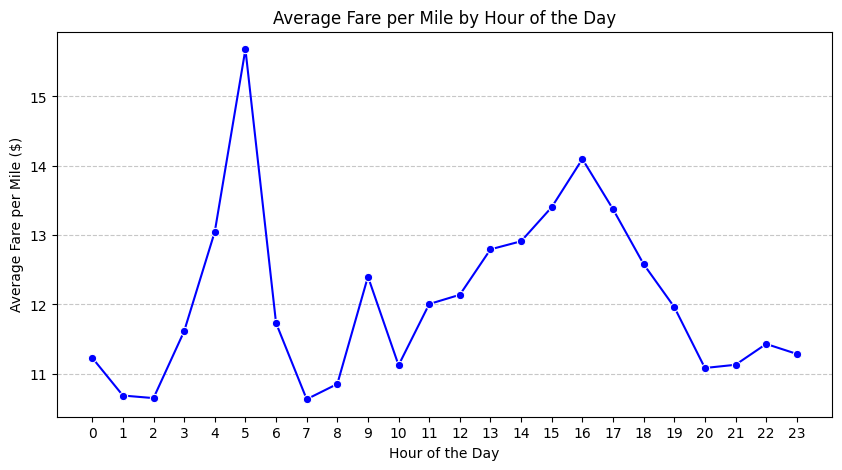

<ipython-input-68-d5a8ca10fc84>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fare_per_mile_by_day, x="pickup_day", y="fare_per_mile", palette="coolwarm")


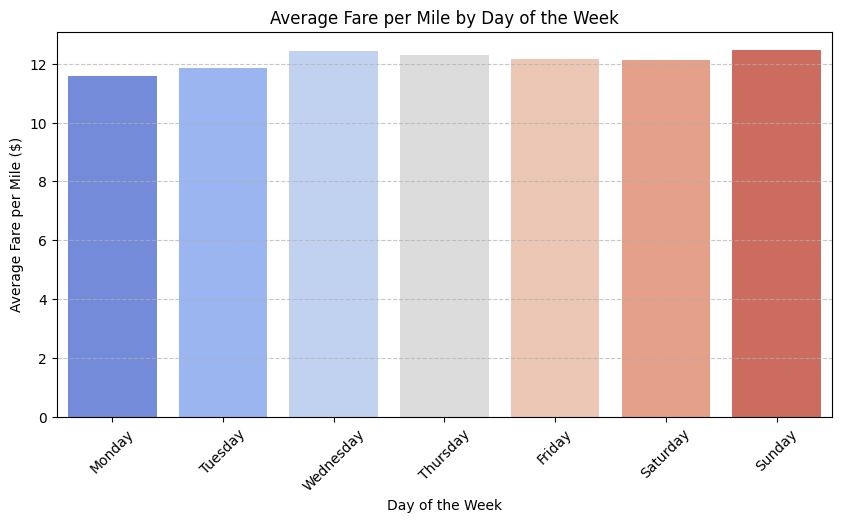

Average Fare per Mile by Hour of the Day:
    pickup_hour  fare_per_mile
0             0      11.229888
1             1      10.686047
2             2      10.648927
3             3      11.613501
4             4      13.048201
5             5      15.680667
6             6      11.731307
7             7      10.632813
8             8      10.852642
9             9      12.401130
10           10      11.123146
11           11      12.005704
12           12      12.139187
13           13      12.794365
14           14      12.911106
15           15      13.403060
16           16      14.096962
17           17      13.373705
18           18      12.580424
19           19      11.962294
20           20      11.083321
21           21      11.129538
22           22      11.429869
23           23      11.286249

Average Fare per Mile by Day of the Week:
  pickup_day  fare_per_mile
1     Monday      11.594144
5    Tuesday      11.852165
6  Wednesday      12.441017
4   Thursday      12.310557


In [68]:

# Remove trips with zero/negative fare or distance
df_filtered = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

# Extract hour and day of the week
df_filtered["pickup_hour"] = df_filtered["tpep_pickup_datetime"].dt.hour
df_filtered["pickup_day"] = df_filtered["tpep_pickup_datetime"].dt.day_name()

# Calculate fare per mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Compute average fare per mile by hour
fare_per_mile_by_hour = df_filtered.groupby("pickup_hour")["fare_per_mile"].mean().reset_index()

# Compute average fare per mile by day of the week
fare_per_mile_by_day = df_filtered.groupby("pickup_day")["fare_per_mile"].mean().reset_index()

# Ensure weekdays are ordered correctly
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fare_per_mile_by_day["pickup_day"] = pd.Categorical(fare_per_mile_by_day["pickup_day"], categories=weekday_order, ordered=True)
fare_per_mile_by_day = fare_per_mile_by_day.sort_values("pickup_day")

# Plot average fare per mile by hour
plt.figure(figsize=(10, 5))
sns.lineplot(data=fare_per_mile_by_hour, x="pickup_hour", y="fare_per_mile", marker="o", color="blue")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Average Fare per Mile by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot average fare per mile by day of the week
plt.figure(figsize=(10, 5))
sns.barplot(data=fare_per_mile_by_day, x="pickup_day", y="fare_per_mile", palette="coolwarm")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Average Fare per Mile by Day of the Week")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print results
print("Average Fare per Mile by Hour of the Day:")
print(fare_per_mile_by_hour)

print("\nAverage Fare per Mile by Day of the Week:")
print(fare_per_mile_by_day)


xi.  Analyse the average fare per mile for the different vendors

<ipython-input-69-3dc2f6ad2531>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]
<ipython-input-69-3dc2f6ad2531>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fare_per_mile_by_vendor, x="VendorID", y="fare_per_mile", palette="viridis")


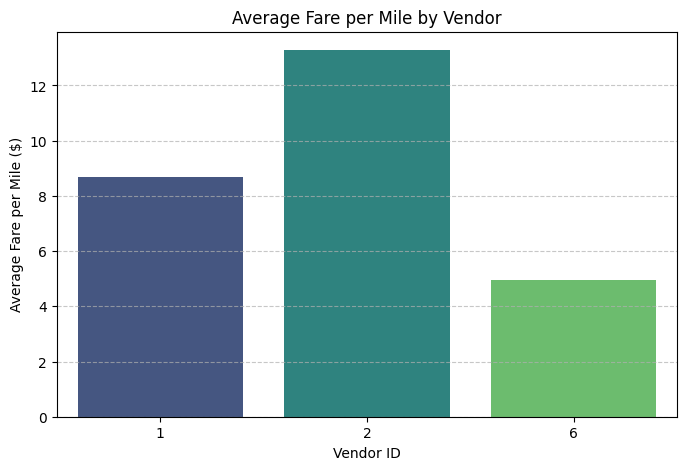

Average Fare per Mile by Vendor:
   VendorID  fare_per_mile
0         1       8.694051
1         2      13.280385
2         6       4.943695


In [69]:
# Remove trips with zero/negative fare or distance
df_filtered = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

# Calculate fare per mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Compute average fare per mile by vendor
fare_per_mile_by_vendor = df_filtered.groupby("VendorID")["fare_per_mile"].mean().reset_index()

# Plot average fare per mile by vendor
plt.figure(figsize=(8, 5))
sns.barplot(data=fare_per_mile_by_vendor, x="VendorID", y="fare_per_mile", palette="viridis")
plt.xlabel("Vendor ID")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Average Fare per Mile by Vendor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print results
print("Average Fare per Mile by Vendor:")
print(fare_per_mile_by_vendor)


xii.  Compare the fare rates of different vendors in a distance-tiered fashion

<ipython-input-70-035dfb83be1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["distance_tier"] = pd.cut(df_filtered["trip_distance"], bins=bins, labels=labels)
<ipython-input-70-035dfb83be1f>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_per_mile_by_vendor_tier = df_filtered.groupby(["VendorID", "distance_tier"])["fare_amount"].mean().reset_index()


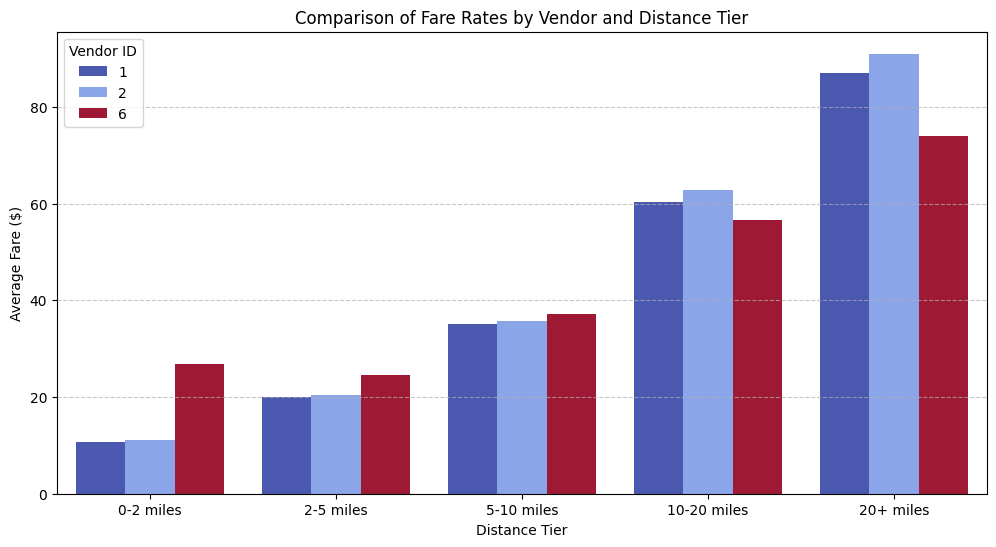

Average Fare Rates by Vendor and Distance Tier:
    VendorID distance_tier  fare_amount
0          1     0-2 miles    10.649089
1          1     2-5 miles    20.073283
2          1    5-10 miles    35.021810
3          1   10-20 miles    60.373368
4          1     20+ miles    87.032861
5          2     0-2 miles    11.062631
6          2     2-5 miles    20.427447
7          2    5-10 miles    35.720591
8          2   10-20 miles    62.783433
9          2     20+ miles    90.999807
10         6     0-2 miles    26.866667
11         6     2-5 miles    24.570000
12         6    5-10 miles    37.200930
13         6   10-20 miles    56.531806
14         6     20+ miles    74.015789


In [70]:
# Remove trips with zero/negative fare or distance
df_filtered = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

# Define distance tiers
bins = [0, 2, 5, 10, 20, float("inf")]
labels = ["0-2 miles", "2-5 miles", "5-10 miles", "10-20 miles", "20+ miles"]
df_filtered["distance_tier"] = pd.cut(df_filtered["trip_distance"], bins=bins, labels=labels)

# Calculate average fare per mile for each vendor and distance tier
fare_per_mile_by_vendor_tier = df_filtered.groupby(["VendorID", "distance_tier"])["fare_amount"].mean().reset_index()

# Plot fare rates across vendors and distance tiers
plt.figure(figsize=(12, 6))
sns.barplot(data=fare_per_mile_by_vendor_tier, x="distance_tier", y="fare_amount", hue="VendorID", palette="coolwarm")
plt.xlabel("Distance Tier")
plt.ylabel("Average Fare ($)")
plt.title("Comparison of Fare Rates by Vendor and Distance Tier")
plt.legend(title="Vendor ID")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print results
print("Average Fare Rates by Vendor and Distance Tier:")
print(fare_per_mile_by_vendor_tier)

xiii. Analyse the tip percentages

<ipython-input-71-91e287424efb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tip_percentage"] = (df_filtered["tip_amount"] / df_filtered["fare_amount"]) * 100


Tip Percentage Statistics:
count    3.262542e+06
mean     2.014599e+01
std      1.144335e+02
min      0.000000e+00
25%      6.410256e+00
50%      2.379747e+01
75%      2.897196e+01
max      2.000000e+05
Name: tip_percentage, dtype: float64


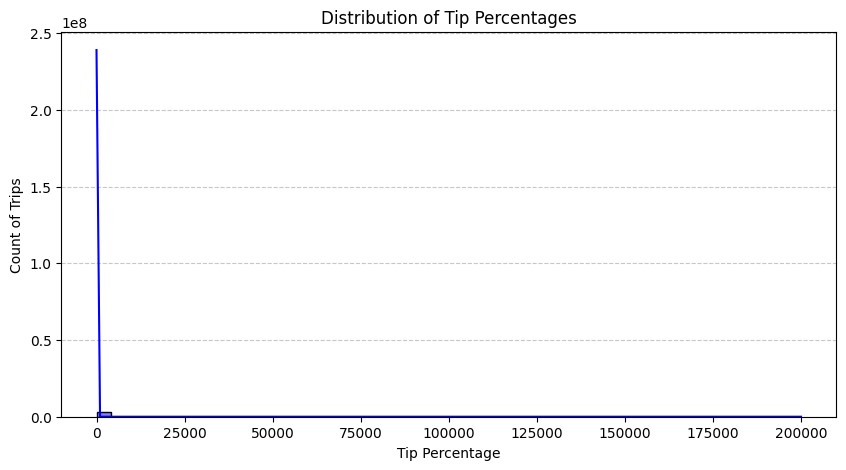

<ipython-input-71-91e287424efb>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tip_by_payment, x="payment_type", y="tip_percentage", palette="coolwarm")


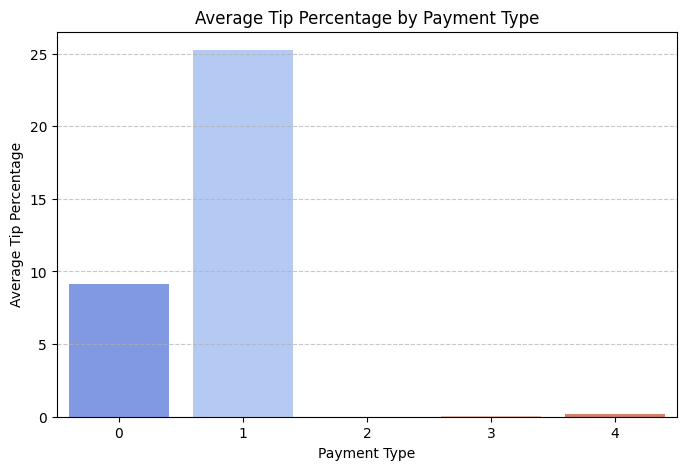

Average Tip Percentage by Payment Type:
   payment_type  tip_percentage
0             0        9.170385
1             1       25.240782
2             2        0.001936
3             3        0.026168
4             4        0.204185


In [71]:
# Remove trips with zero/negative fare or tip amounts
df_filtered = df[(df["fare_amount"] > 0) & (df["tip_amount"] >= 0)]

# Calculate tip percentage
df_filtered["tip_percentage"] = (df_filtered["tip_amount"] / df_filtered["fare_amount"]) * 100

# Summary statistics
tip_stats = df_filtered["tip_percentage"].describe()
print("Tip Percentage Statistics:")
print(tip_stats)

# Visualize tip percentage distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered["tip_percentage"], bins=50, kde=True, color="blue")
plt.xlabel("Tip Percentage")
plt.ylabel("Count of Trips")
plt.title("Distribution of Tip Percentages")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Analyze tip percentage by payment type
tip_by_payment = df_filtered.groupby("payment_type")["tip_percentage"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=tip_by_payment, x="payment_type", y="tip_percentage", palette="coolwarm")
plt.xlabel("Payment Type")
plt.ylabel("Average Tip Percentage")
plt.title("Average Tip Percentage by Payment Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print results
print("Average Tip Percentage by Payment Type:")
print(tip_by_payment)

xiv. Analyse the trends in passenger count

<ipython-input-73-305a60b876e4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=passenger_trends.index, y=passenger_trends.values, palette="coolwarm")


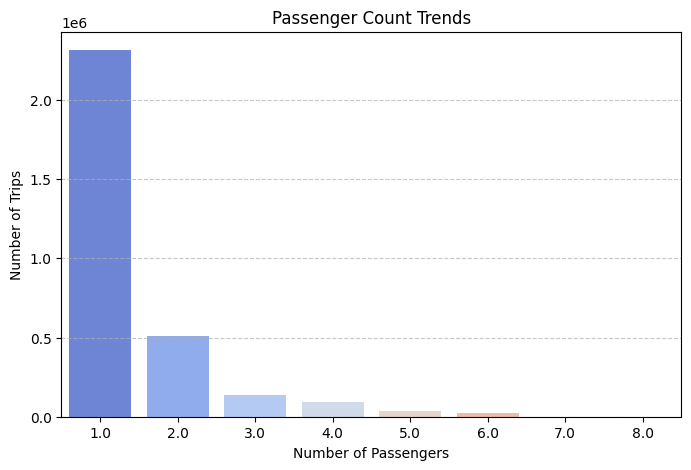

Passenger Count Distribution:
passenger_count
1.0    2315148
2.0     506566
3.0     135072
4.0      90971
5.0      39035
6.0      24003
7.0          6
8.0         14
Name: count, dtype: int64


In [73]:
# Remove trips with invalid passenger counts (negative or zero)
df_filtered = df[df["passenger_count"] > 0]

###  Passenger Count Trends Over Time ###
# Group by passenger count and get trip frequency
passenger_trends = df_filtered["passenger_count"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=passenger_trends.index, y=passenger_trends.values, palette="coolwarm")
plt.xlabel("Number of Passengers")
plt.ylabel("Number of Trips")
plt.title("Passenger Count Trends")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print("Passenger Count Distribution:")
print(passenger_trends)



xv.  Analyse the variation of passenger counts across zones

<ipython-input-74-4516bf551750>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zone_passenger_counts.sort_values(by="passenger_count", ascending=False).head(20),


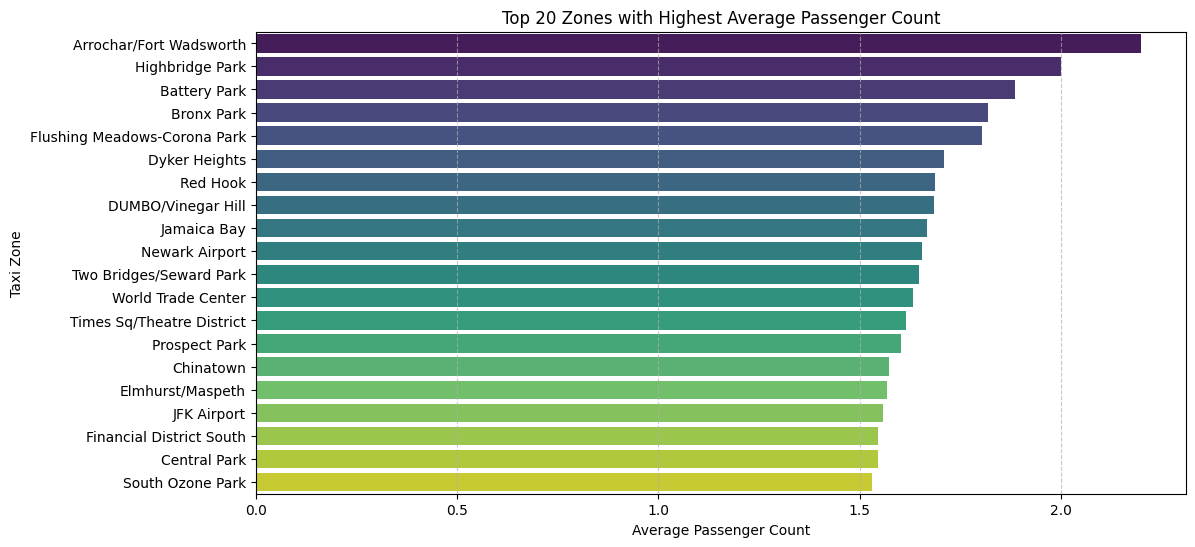

Top Zones with Highest Average Passenger Counts:
                             zone  passenger_count
2         Arrochar/Fort Wadsworth         2.200000
106               Highbridge Park         2.000000
8                    Battery Park         1.887010
26                     Bronx Park         1.818182
86   Flushing Meadows-Corona Park         1.803867
61                  Dyker Heights         1.710000
180                      Red Hook         1.687204
58             DUMBO/Vinegar Hill         1.684633
118                   Jamaica Bay         1.666667
159                Newark Airport         1.653846


In [74]:
###  Variation of Passenger Counts Across Zones ###
# Merge trip data with zone data
df_merged = df_filtered.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")

# Group by zones and calculate average passenger count per trip
zone_passenger_counts = df_merged.groupby("zone")["passenger_count"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=zone_passenger_counts.sort_values(by="passenger_count", ascending=False).head(20),
            x="passenger_count", y="zone", palette="viridis")
plt.xlabel("Average Passenger Count")
plt.ylabel("Taxi Zone")
plt.title("Top 20 Zones with Highest Average Passenger Count")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

print("Top Zones with Highest Average Passenger Counts:")
print(zone_passenger_counts.sort_values(by="passenger_count", ascending=False).head(10))

xvi. Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

<ipython-input-75-dc1314d1cb2f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=extra_charges_by_zone.head(15), y="zone", x="extra", palette="coolwarm")


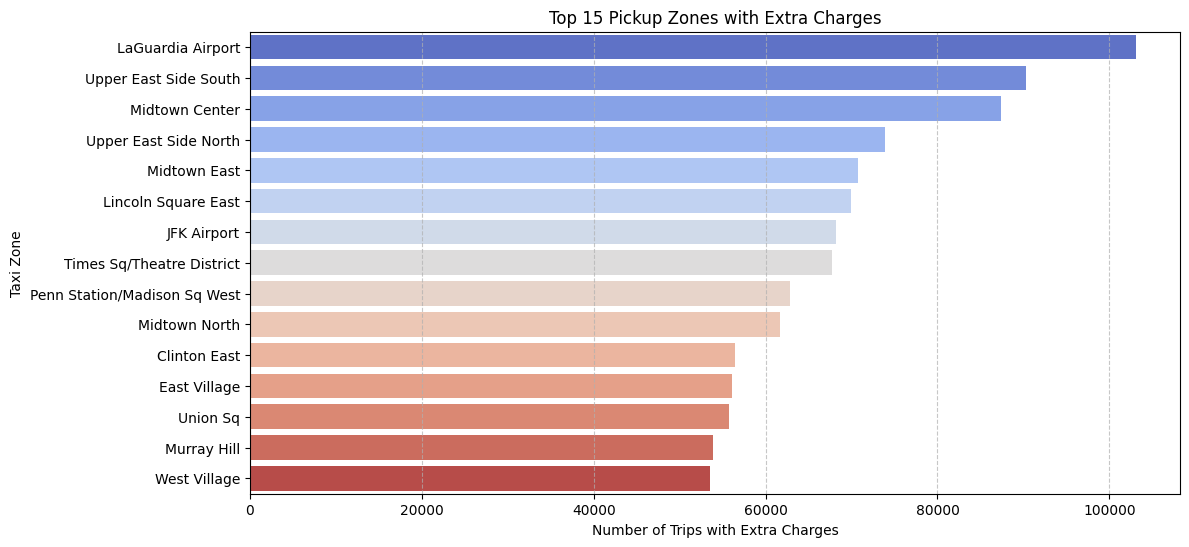

Top Pickup Zones with Extra Charges:
                             zone   extra
117             LaGuardia Airport  103051
210         Upper East Side South   90350
139                Midtown Center   87391
209         Upper East Side North   73906
140                  Midtown East   70701
121           Lincoln Square East   69988
107                   JFK Airport   68217
203     Times Sq/Theatre District   67751
162  Penn Station/Madison Sq West   62807
141                 Midtown North   61632


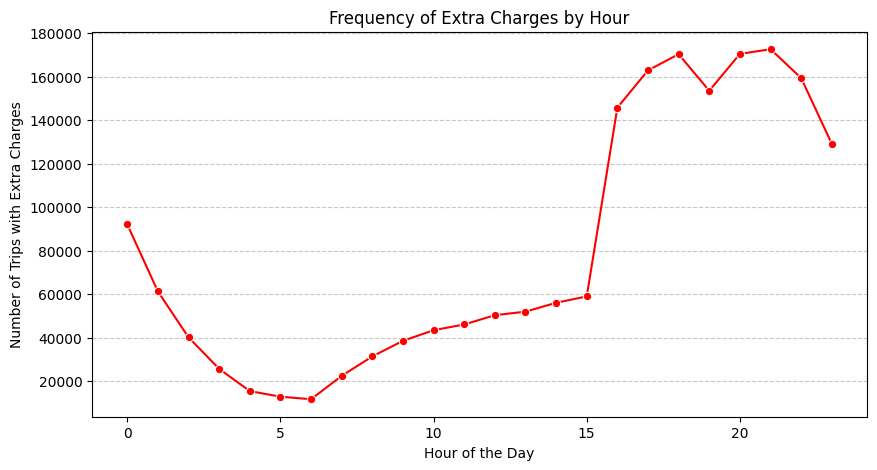

Extra Charges Applied by Hour:
pickup_hour
0      92081
1      61245
2      40104
3      25606
4      15371
5      12794
6      11630
7      22384
8      31327
9      38506
10     43385
11     46034
12     50311
13     51930
14     56012
15     58951
16    145832
17    162998
18    170411
19    153589
20    170564
21    172712
22    159459
23    129144
Name: extra, dtype: int64


In [75]:
# Filter data where extra charges are applied
df_extra_charges = df[df["extra"] > 0]  # 'extra' column represents additional charges

### 1️⃣ Extra Charges by Pickup & Drop-off Zones ###
# Merge with taxi zones data
df_extra_charges = df_extra_charges.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")

# Count occurrences of extra charges per zone
extra_charges_by_zone = df_extra_charges.groupby("zone")["extra"].count().reset_index()
extra_charges_by_zone = extra_charges_by_zone.sort_values(by="extra", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=extra_charges_by_zone.head(15), y="zone", x="extra", palette="coolwarm")
plt.xlabel("Number of Trips with Extra Charges")
plt.ylabel("Taxi Zone")
plt.title("Top 15 Pickup Zones with Extra Charges")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

print("Top Pickup Zones with Extra Charges:")
print(extra_charges_by_zone.head(10))

### 2️⃣ Extra Charges by Time of Day ###
df_extra_charges["pickup_hour"] = df_extra_charges["tpep_pickup_datetime"].dt.hour
extra_charges_by_hour = df_extra_charges.groupby("pickup_hour")["extra"].count()

plt.figure(figsize=(10, 5))
sns.lineplot(x=extra_charges_by_hour.index, y=extra_charges_by_hour.values, marker="o", color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips with Extra Charges")
plt.title("Frequency of Extra Charges by Hour")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print("Extra Charges Applied by Hour:")
print(extra_charges_by_hour)